In [10]:
import pandas as pd
import numpy as np
import seaborn as sns

from dpks import QuantMatrix

In [11]:
def preprocess_design_matrix(design_matrix):

    design_matrix = design_matrix[design_matrix['sofa_liver_baseline'] == 0.0]

    design_matrix['max_liver_diff'] = np.max(
        design_matrix[
            [
                'sofa_liver_day1', 
                'sofa_liver_day2', 
                'sofa_liver_day3'
            ]
        ], 
        axis=1
    )

    design_matrix['group'] = np.where(
        design_matrix['max_liver_diff'] > 0, 2, 1
    )

    # design_matrix = design_matrix[
    #     (design_matrix['bili_highest_72h'] < 20) |
    #     (design_matrix['bili_highest_72h'] > 32)
    # ].copy()

    # design_matrix['group'] = np.where(
    #     design_matrix['bili_highest_72h'] > 32, 2, 1
    # )

    design_matrix['sample'] = design_matrix['injection']

    return design_matrix

In [12]:
def preprocess_data(raw_data, design_matrix):

    quant_matrix = QuantMatrix(
        quantification_file=raw_data[['Protein'] + [sample for sample in design_matrix['sample'].values]].copy(),
        design_matrix_file=design_matrix,
        annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
    )

    quant_data = quant_matrix.to_df()
    
    quant_data = quant_data[~((quant_data["ProteinLabel"].str.startswith("HV")) | (quant_data["ProteinLabel"].str.startswith("LV")) | quant_data["ProteinLabel"].str.startswith("KV"))]
    quant_data = quant_data[~quant_data["ProteinLabel"].str.startswith("IG")]
    quant_data = quant_data[~((quant_data["ProteinLabel"] == "HBA_HUMAN") | (quant_data["ProteinLabel"] == "HBB_HUMAN") | (quant_data["ProteinLabel"] == "HBD_HUMAN") | (quant_data["ProteinLabel"] == "HEMO_HUMAN"))]

    quant_matrix = QuantMatrix(
        quantification_file=quant_data,
        design_matrix_file=design_matrix,
        annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
    )

    return quant_matrix     

# Model Training

In [13]:
ms_data = pd.read_csv(
    "../0_data/proteins_train_filtered.tsv"
    , sep="\t"
)

In [14]:
design_matrix_otrain = pd.read_csv(
    "../0_data/design_matrix_train.tsv",
    sep='\t'
)

In [15]:
for col in design_matrix_otrain.columns:

    if "bili" in col:

        print(col)

bili_emergency_department


In [16]:
design_matrix_train = preprocess_design_matrix(design_matrix_otrain.copy())

/tmp/ipykernel_1035681/1885942666.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  design_matrix['max_liver_diff'] = np.max(
/tmp/ipykernel_1035681/1885942666.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  design_matrix['group'] = np.where(
/tmp/ipykernel_1035681/1885942666.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

<Axes: xlabel='max_liver_diff', ylabel='Count'>

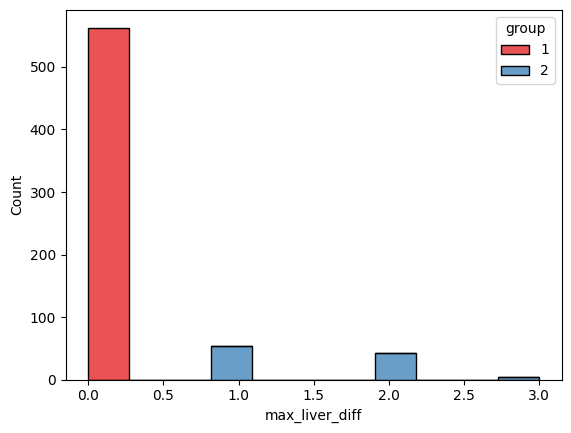

In [17]:
sns.histplot(
    design_matrix_train,
    x="max_liver_diff",
    hue="group",
    palette="Set1",
    multiple="stack"
)

In [18]:
design_matrix_train['group'].value_counts()

group
1    563
2     99
Name: count, dtype: int64

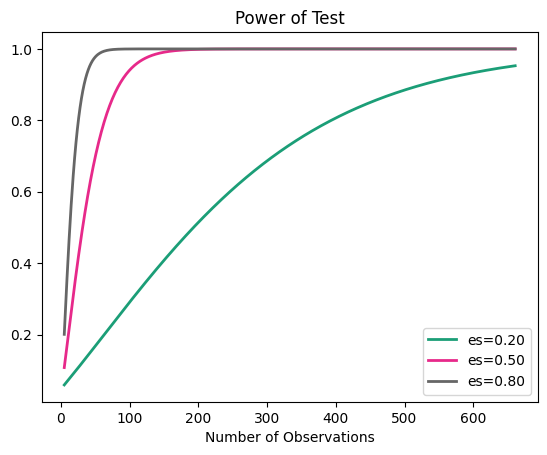

In [19]:
from statsmodels.stats.power import TTestIndPower
import matplotlib.pyplot as plt

# parameters for power analysis
effect_sizes = np.array([0.2, 0.5, 0.8])
sample_sizes = np.array(range(5, design_matrix_train.shape[0]))


analysis = TTestIndPower()

analysis.plot_power(dep_var='nobs', nobs=sample_sizes, effect_size=effect_sizes)
plt.show()

In [20]:
quant_matrix_train = preprocess_data(ms_data, design_matrix=design_matrix_train)

In [21]:
quant_matrix_train = quant_matrix_train.compare(
    method="linregress",
    comparisons=(2,1),
    min_samples_per_group=2,
    level="protein",
    multiple_testing_correction_method="fdr_tsbh"
)

In [22]:
quant_matrix_train.write("de_results/liver_de_proteins.tsv")

In [23]:
quant_matrix_de = quant_matrix_train.to_df()

<Axes: xlabel='Log2FoldChange2-1', ylabel='-Log10CorrectedPValue2-1'>

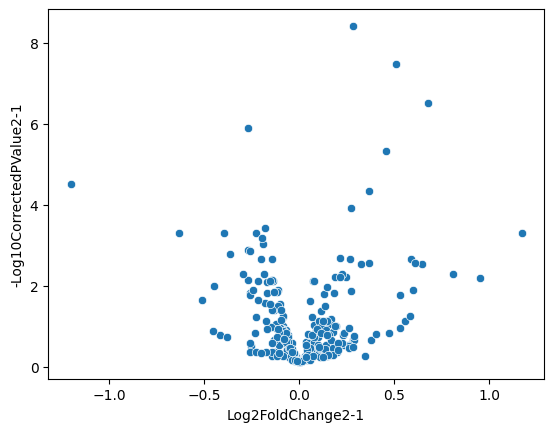

In [24]:
sns.scatterplot(
    data=quant_matrix_de,
    x="Log2FoldChange2-1",
    y="-Log10CorrectedPValue2-1"
)

In [25]:
qm_filtered = (
    
    QuantMatrix(
        quantification_file=quant_matrix_de,
        design_matrix_file=design_matrix_train
    )
    
)

In [26]:
training_data, y = qm_filtered.to_ml(feature_column="ProteinLabel")

In [27]:
protein_columns = training_data.columns.to_list()

In [28]:
len(protein_columns)

287

In [29]:
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.impute import SimpleImputer

X = training_data.copy()

protein_scaler = StandardScaler()

X[protein_columns] = protein_scaler.fit_transform(X[protein_columns])

X = X.copy()

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier


protein_clf = LogisticRegression(
    random_state=42,
    #penalty="l1",
    class_weight="balanced",
    #C=0.1,
    #solver="liblinear",
    max_iter=1000
)

# protein_clf = BaggingClassifier(
#     estimator=protein_clf,
#     random_state=42
# )

In [31]:
from cleanlab.filter import find_label_issues
from sklearn.model_selection import cross_val_predict

pred_probs = cross_val_predict(protein_clf, X, y.values.ravel(), cv=3, method="predict_proba")

label_issues = find_label_issues(
    labels=y.values.ravel(),
    pred_probs=pred_probs,
    return_indices_ranked_by='self_confidence'  # Ranks by likelihood of being mislabeled
)

/srv/data1/home/aaron/envs/miniconda3/envs/revisionenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [32]:
mask = np.ones(len(y.values.ravel()), dtype=bool)

mask[label_issues] = False

In [33]:
X = X.iloc[mask, :].copy()
y = y.iloc[mask, :].copy()

In [34]:
y['label'].value_counts()

label
0    488
1     42
Name: count, dtype: int64

In [35]:
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight


class_weight = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y.values.ravel()),
    y=y.values.ravel()
)

class_weight = dict(zip(np.unique(y.values.ravel()), class_weight))

class_weight

{0: 0.5430327868852459, 1: 6.309523809523809}

In [36]:
len(protein_columns)

287

In [37]:
from mrmr import mrmr_classif
selected_proteins = mrmr_classif(X=X[protein_columns], y=y.values.ravel(), K=50)

100%|██████████| 50/50 [00:21<00:00,  2.32it/s]


In [38]:
selected_proteins

['BGH3_HUMAN',
 'FIBB_HUMAN',
 'APOH_HUMAN',
 'ALDOB_HUMAN',
 'FA7_HUMAN',
 'ICAM1_HUMAN',
 'AMPN_HUMAN',
 'TIMP1_HUMAN',
 'FHR4_HUMAN',
 'HEP2_HUMAN',
 'LDHA_HUMAN',
 'PLTP_HUMAN',
 'PIGR_HUMAN',
 'ENPL_HUMAN',
 'PROC_HUMAN',
 'H4_HUMAN',
 'APOC4_HUMAN',
 'FCG3A_HUMAN',
 'C4BPB_HUMAN',
 'A1AT_HUMAN',
 'CRIS3_HUMAN',
 'SPP24_HUMAN',
 'C163A_HUMAN',
 'LKHA4_HUMAN',
 'CATB_HUMAN',
 'APOC3_HUMAN',
 'FIBG_HUMAN',
 'PZP_HUMAN',
 'SAMP_HUMAN',
 'LYAM1_HUMAN',
 'ENOA_HUMAN',
 'APOC1_HUMAN',
 'CATD_HUMAN',
 'QSOX1_HUMAN',
 'PLMN_HUMAN',
 'PROZ_HUMAN',
 'LBP_HUMAN',
 'FHR3_HUMAN',
 'VCAM1_HUMAN',
 'VWF_HUMAN',
 'APOA_HUMAN',
 'CSPG2_HUMAN',
 'CLUS_HUMAN',
 'C4BPA_HUMAN',
 'EPCR_HUMAN',
 'PCSK9_HUMAN',
 'TENX_HUMAN',
 'SEPP1_HUMAN',
 'GSTO1_HUMAN',
 'APOF_HUMAN']

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier


protein_clf = LogisticRegression(
    class_weight=class_weight,
    random_state=42
)

In [40]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate

cv = StratifiedKFold(3)
eval_result = cross_validate(
    protein_clf, X[selected_proteins], y.values.ravel(), scoring=("recall", "precision", "accuracy", "balanced_accuracy"), cv=cv, #params={"sample_weight": sample_weight}
)
eval_result['test_recall'].mean(), eval_result['test_precision'].mean(), eval_result['test_accuracy'].mean(), eval_result['test_balanced_accuracy'].mean()

(0.6190476190476191, 0.411005291005291, 0.8981338811847287, 0.7706058868294724)

In [41]:
from dpks.interpretation import BootstrapInterpreter

protein_interpreter = BootstrapInterpreter(
    n_iterations=100,
    feature_names=selected_proteins,
    downsample_background=True,
    shuffle_iterations=100
)

In [42]:
protein_interpreter.fit(X[selected_proteins].values, y.values.ravel(), protein_clf)

In [43]:
protein_importances = protein_interpreter.results_.sort_values("mean_importance", ascending=False)

In [44]:
protein_importances.head(20)

,feature,iteration_0_importance,iteration_0_rank,iteration_1_importance,iteration_1_rank,iteration_2_importance,iteration_2_rank,iteration_3_importance,iteration_3_rank,iteration_4_importance,...,iteration_98_importance,iteration_98_rank,iteration_99_importance,iteration_99_rank,mean_importance,median_importance,stdev_importance,mean_rank,median_rank,stdev_rank
27,PZP_HUMAN,0.314096,13.0,0.873116,2.0,0.384342,16.0,0.409900,11.0,0.566580,...,0.835153,2.0,0.977477,2.0,0.652810,0.659041,0.264621,9.51,7.0,9.405022
12,PIGR_HUMAN,0.253088,19.0,0.333534,16.0,0.626821,6.0,0.764376,2.0,0.784730,...,0.013747,50.0,0.354844,14.0,0.547359,0.530796,0.281795,13.64,11.0,12.379129
38,VCAM1_HUMAN,0.292297,15.0,0.403981,12.0,0.988105,2.0,0.328679,18.0,0.515578,...,0.356381,13.0,0.456532,7.0,0.525001,0.489712,0.280163,14.64,11.0,11.690037
6,AMPN_HUMAN,0.346224,6.0,0.759183,4.0,0.269766,31.0,0.335797,14.0,0.591098,...,0.417439,10.0,0.455825,8.0,0.505493,0.472231,0.196569,12.96,13.0,7.801735
18,C4BPB_HUMAN,0.436864,3.0,0.590701,5.0,0.784582,4.0,0.473243,8.0,0.444289,...,0.493329,9.0,0.398721,11.0,0.471206,0.443160,0.240391,15.99,13.0,12.142666
3,ALDOB_HUMAN,0.326787,11.0,0.003152,50.0,0.580283,9.0,0.426980,10.0,0.941546,...,0.747785,3.0,0.241920,25.0,0.466821,0.431110,0.254332,16.40,13.5,11.981467
20,CRIS3_HUMAN,0.238541,21.0,0.132489,28.0,0.333214,24.0,0.269685,23.0,0.605967,...,1.000000,1.0,0.387033,13.0,0.465709,0.461794,0.218668,15.75,13.0,10.548948
26,FIBG_HUMAN,0.280343,17.0,0.588924,6.0,0.237761,35.0,0.246195,25.0,0.069637,...,0.331562,15.0,0.234516,26.0,0.447656,0.422088,0.204409,16.45,14.0,10.730279
23,LKHA4_HUMAN,0.342411,7.0,0.211248,21.0,0.225673,38.0,0.646062,6.0,0.897071,...,0.103296,41.0,1.000000,1.0,0.432482,0.410778,0.284462,19.81,16.0,15.006191
0,BGH3_HUMAN,0.319566,12.0,0.769143,3.0,1.000000,1.0,0.209383,31.0,0.331761,...,0.134305,36.0,0.503702,5.0,0.429597,0.428456,0.269225,19.76,17.5,14.593564


In [45]:
selected_proteins = protein_importances.head(10)['feature'].to_list()

In [46]:
from dpks.interpretation import Classifier


protein_clf = Classifier(protein_clf)

In [47]:
selected_features = selected_proteins[:10]

In [48]:
for feature in selected_features:

    print(feature)

PZP_HUMAN
PIGR_HUMAN
VCAM1_HUMAN
AMPN_HUMAN
C4BPB_HUMAN
ALDOB_HUMAN
CRIS3_HUMAN
FIBG_HUMAN
LKHA4_HUMAN
BGH3_HUMAN


In [49]:
protein_clf = LogisticRegression(
    class_weight=class_weight,
    random_state=42
)

In [50]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate

cv = StratifiedKFold(3, shuffle=True, random_state=42)
eval_result = cross_validate(
    protein_clf, X[selected_features], y.values.ravel(), scoring=("recall", "precision", "accuracy", "balanced_accuracy"), cv=cv, #params={"sample_weight": sample_weight}
)
eval_result['test_recall'].mean(), eval_result['test_precision'].mean(), eval_result['test_accuracy'].mean(), eval_result['test_balanced_accuracy'].mean()

(0.8333333333333334, 0.3870931537598204, 0.8830144667009074, 0.860322149006539)

In [51]:
cv = StratifiedKFold(3, shuffle=True, random_state=42)
eval_result = cross_validate(
    protein_clf, X[protein_columns], y.values.ravel(), scoring=("recall", "precision", "accuracy", "balanced_accuracy"), cv=cv, #params={"sample_weight": sample_weight}
)
eval_result['test_recall'].mean(), eval_result['test_precision'].mean(), eval_result['test_accuracy'].mean(), eval_result['test_balanced_accuracy'].mean()

(0.5714285714285715,
 0.6583139083139083,
 0.9434493237459339,
 0.7734317236703058)

In [52]:
from dpks.interpretation import BootstrapInterpreter

final_protein_interpreter = BootstrapInterpreter(
    n_iterations=100,
    feature_names=selected_features,
    downsample_background=True,
    shuffle_iterations=100
)

In [53]:
final_protein_interpreter.fit(X[selected_features].values, y.values.ravel(), protein_clf)

In [54]:
final_protein_importances = final_protein_interpreter.results_.sort_values("mean_importance", ascending=False)

In [55]:
final_protein_importances

,feature,iteration_0_importance,iteration_0_rank,iteration_1_importance,iteration_1_rank,iteration_2_importance,iteration_2_rank,iteration_3_importance,iteration_3_rank,iteration_4_importance,...,iteration_98_importance,iteration_98_rank,iteration_99_importance,iteration_99_rank,mean_importance,median_importance,stdev_importance,mean_rank,median_rank,stdev_rank
4,C4BPB_HUMAN,1.000000,1.0,0.809080,2.0,1.000000,1.0,0.693070,4.0,1.000000,...,1.000000,1.0,0.785006,4.0,0.901330,1.000000,0.145779,2.05,1.0,1.552938
7,FIBG_HUMAN,0.657138,2.0,1.000000,1.0,0.788081,3.0,0.873488,2.0,0.769428,...,0.637705,5.0,0.687333,5.0,0.749550,0.734189,0.178047,3.23,3.0,1.757265
0,PZP_HUMAN,0.167282,10.0,0.609214,3.0,0.336723,8.0,0.692588,5.0,0.436944,...,0.762005,4.0,1.000000,1.0,0.598448,0.583783,0.233627,5.00,5.0,2.407899
5,ALDOB_HUMAN,0.577993,5.0,0.352804,6.0,0.707752,4.0,0.540094,7.0,0.854514,...,0.948396,2.0,0.681672,6.0,0.554550,0.539526,0.210051,5.39,5.0,2.403260
1,PIGR_HUMAN,0.379432,7.0,0.208345,7.0,0.616247,6.0,1.000000,1.0,0.730438,...,0.412936,7.0,0.353286,8.0,0.548603,0.547118,0.219283,5.20,5.0,2.382597
9,BGH3_HUMAN,0.633975,3.0,0.513592,4.0,0.839107,2.0,0.594735,6.0,0.464590,...,0.592756,6.0,0.808053,3.0,0.543513,0.528196,0.254543,5.51,6.0,2.641912
8,LKHA4_HUMAN,0.428581,6.0,0.112420,9.0,0.110182,10.0,0.720827,3.0,0.765619,...,0.336978,8.0,0.845189,2.0,0.452161,0.427300,0.243786,6.39,7.0,2.593290
3,AMPN_HUMAN,0.594771,4.0,0.512191,5.0,0.274336,9.0,0.261909,9.0,0.361613,...,0.287954,9.0,0.413330,7.0,0.432643,0.410219,0.195474,6.82,7.0,2.253527
6,CRIS3_HUMAN,0.256713,9.0,0.113295,8.0,0.633092,5.0,0.270608,8.0,0.462827,...,0.814328,3.0,0.232234,9.0,0.400267,0.374098,0.245973,6.85,8.0,2.629956
2,VCAM1_HUMAN,0.319603,8.0,0.040370,10.0,0.349026,7.0,0.031039,10.0,0.063210,...,0.168399,10.0,0.078545,10.0,0.247346,0.206336,0.202747,8.56,9.0,1.854942


In [56]:
final_protein_importances.to_csv(
    "feature_importances/liver_protein_importances.tsv",
    sep="\t",
    index=False
)

# Model Testing

In [57]:
ms_data_test = pd.read_csv(
    "../0_data/proteins_test_filtered.tsv"
    , sep="\t"
)
design_matrix_test = pd.read_csv(
    "../0_data/design_matrix_test.tsv",
    sep='\t'
)

In [58]:
design_matrix_test = preprocess_design_matrix(design_matrix_test)

quant_matrix_test = preprocess_data(ms_data_test, design_matrix=design_matrix_test)

In [59]:
quant_matrix_test_df = quant_matrix_test.to_df()
#quant_matrix_test_df = quant_matrix_test_df[quant_matrix_test_df['ProteinLabel'].isin(selected_features)]

In [60]:
qm_filtered_test = (
    
    QuantMatrix(
        quantification_file=quant_matrix_test_df,
        design_matrix_file=design_matrix_test
    )
    
)

In [61]:
testing_data, y_test = qm_filtered_test.to_ml(feature_column="ProteinLabel")

In [62]:
X_test = testing_data.copy()

X_test[protein_scaler.feature_names_in_] = protein_scaler.transform(X_test[protein_scaler.feature_names_in_])

X_test = X_test.copy()

In [63]:
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

decision_tree = DecisionTreeClassifier(random_state=42)
random_forest = RandomForestClassifier(random_state=42)
svc = SVC(random_state=42)
knn = KNeighborsClassifier()
naive_bayes = GaussianNB()
mlp = MLPClassifier(random_state=42)


lr_clf = LogisticRegression(
    class_weight=class_weight,
    random_state=42
)

# lr_clf = BaggingClassifier(
#     estimator=lr_clf,
#     random_state=42
# )

xgb_clf = XGBClassifier(
    max_depth=5,
    min_child_weight=5,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    learning_rate=0.01,
    n_estimators=1000,
    objective='binary:logistic',
    random_state=42,
    eval_metric='logloss',
    n_jobs=1
)


In [64]:
lr_clf.fit(X[selected_features], y.values.ravel(), )
xgb_clf.fit(X[selected_features], y.values.ravel(), )
decision_tree.fit(X[selected_features], y.values.ravel(), ) 
random_forest.fit(X[selected_features], y.values.ravel(), )
svc.fit(X[selected_features], y.values.ravel(), )
knn.fit(X[selected_features], y.values.ravel()) 
naive_bayes.fit(X[selected_features], y.values.ravel(), ) 
mlp.fit(X[selected_features], y.values.ravel())

MLPClassifier(random_state=42)

In [65]:
from sklearn.metrics import f1_score

lr_predictions = lr_clf.predict(X_test[selected_features])
lr_ba = f1_score(y_test.values.ravel(), lr_predictions)

xgb_predictions = xgb_clf.predict(X_test[selected_features])
xgb_ba = f1_score(y_test.values.ravel(), xgb_predictions)

decision_tree_predictions = decision_tree.predict(X_test[selected_features])
decision_tree_ba = f1_score(y_test.values.ravel(), decision_tree_predictions)

rf_predictions = random_forest.predict(X_test[selected_features])
rf_ba = f1_score(y_test.values.ravel(), rf_predictions)

svc_predictions = svc.predict(X_test[selected_features])
svc_ba = f1_score(y_test.values.ravel(), svc_predictions)

knn_predictions = knn.predict(X_test[selected_features])
knn_ba = f1_score(y_test.values.ravel(), knn_predictions)

nb_predictions = naive_bayes.predict(X_test[selected_features])
nb_ba = f1_score(y_test.values.ravel(), nb_predictions)

mlp_predictions = mlp.predict(X_test[selected_features])
mlp_ba = f1_score(y_test.values.ravel(), mlp_predictions)

In [66]:
lr_ba, xgb_ba, decision_tree_ba, rf_ba, svc_ba, knn_ba, nb_ba, mlp_ba

(0.36619718309859156,
 0.336,
 0.27710843373493976,
 0.31666666666666665,
 0.21818181818181817,
 0.22018348623853212,
 0.4175824175824176,
 0.35384615384615387)

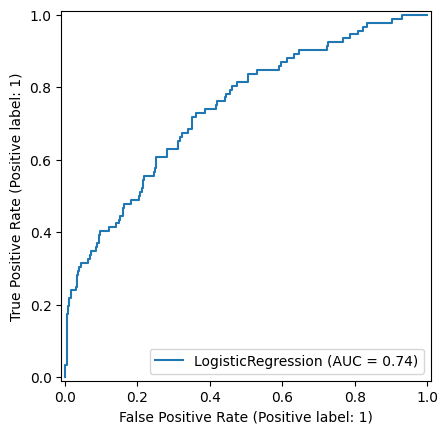

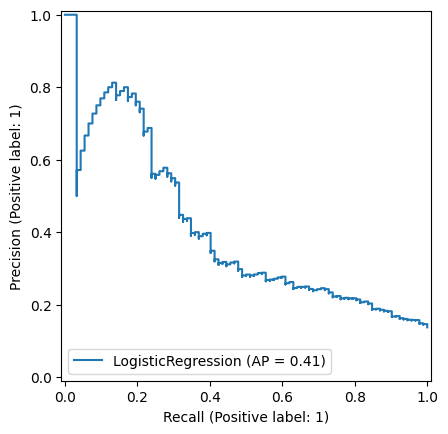

In [67]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

RocCurveDisplay.from_estimator(
    lr_clf, X_test[selected_features], y_test.values.ravel()
)


PrecisionRecallDisplay.from_estimator(
    lr_clf, X_test[selected_features], y_test.values.ravel()
)





In [68]:
from sklearn.metrics import roc_curve

y_probs = lr_clf.predict_proba(X_test[selected_features])[:, 1]

# Compute ROC curve metrics
fpr, tpr, thresholds = roc_curve( y_test.values.ravel(), y_probs)

# Create a DataFrame to store the metrics
roc_df = pd.DataFrame({
    'False Positive Rate': fpr,
    'True Positive Rate': tpr,
    'Threshold': thresholds
})


In [69]:
roc_df.to_csv(
    "roc/liver.tsv",
    sep="\t"
)

# Probability Prediction

In [70]:
design_matrix_test = pd.read_csv(
    "../0_data/design_matrix_test.tsv",
    sep='\t'
)

design_matrix_test['sample'] = design_matrix_test['injection']
design_matrix_test['group'] = 1

quant_matrix_predict = QuantMatrix(
    quantification_file=ms_data_test,
    design_matrix_file=design_matrix_test,
    annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
).impute(method="uniform_percentile", percentile=0.01)

predict_data, y_test_alll = quant_matrix_predict.to_ml(feature_column="ProteinLabel")

In [71]:
predict_data = predict_data[protein_columns].copy()

In [72]:
predict_data[protein_columns] = protein_scaler.transform(predict_data[protein_columns])

In [73]:
predict_data['liver_probability'] = lr_clf.predict_proba(predict_data[selected_features])[:, 1]

In [74]:
design_matrix_test = design_matrix_test.set_index("injection").join(
    predict_data['liver_probability']
).reset_index()

In [75]:
predict_data[['liver_probability']].to_csv(
    "predictions_test/liver.tsv",
    sep="\t"
)

<Axes: xlabel='liver_probability', ylabel='Count'>

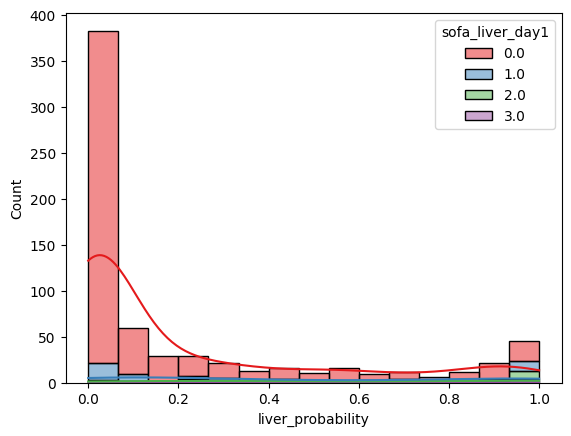

In [76]:
sns.histplot(
    data=design_matrix_test,
    x="liver_probability",
    hue="sofa_liver_day1",
    palette="Set1", 
    kde=True,
    multiple="stack"
)

In [77]:
ms_data_val = pd.read_csv(
    "../0_data/proteins_val_filtered.tsv"
    , sep="\t"
)

design_matrix_val = pd.read_csv(
    "../0_data/design_matrix_validation.tsv",
    sep='\t'
)

design_matrix_val['sample'] = design_matrix_val['injection']
design_matrix_val['group'] = 1

quant_matrix_val = QuantMatrix(
    quantification_file=ms_data_val,
    design_matrix_file=design_matrix_val,
    annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
)

val_data, y_val = quant_matrix_val.to_ml(feature_column="ProteinLabel")

In [78]:
val_data = val_data[protein_columns].copy()

In [79]:
val_data[protein_columns] = protein_scaler.transform(val_data[protein_columns])

In [80]:
val_data['liver_probability'] = lr_clf.predict_proba(val_data[selected_features])[:, 1]

In [81]:
design_matrix_val = design_matrix_val.set_index("injection").join(
    val_data['liver_probability']
).reset_index()

In [82]:
val_data[['liver_probability']].to_csv(
    "predictions_val/liver.tsv",
    sep="\t"
)

<Axes: xlabel='liver_probability', ylabel='Count'>

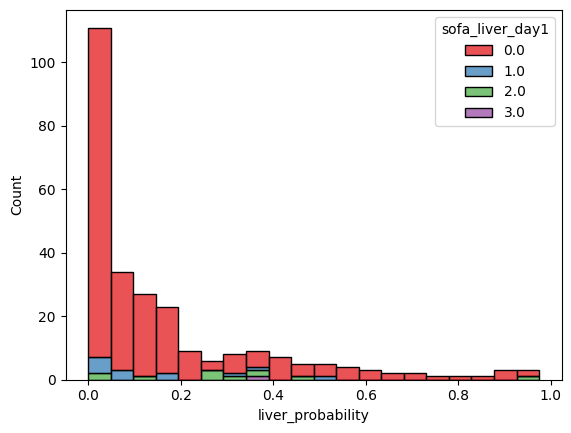

In [83]:
sns.histplot(
    data=design_matrix_val,
    x="liver_probability",
    hue="sofa_liver_day1",
    palette="Set1", 
    #kde=True,
    multiple="stack", 
    bins=20
)

In [84]:
ms_data_hero = pd.read_csv(
    "../0_data/proteins_hero_filtered.tsv"
    , sep="\t"
)

design_matrix_hero = pd.read_csv(
    "../0_data/design_matrix_hero.tsv",
    sep='\t'
)

design_matrix_hero['sample'] = design_matrix_hero['injection']
design_matrix_hero['group'] = 1

quant_matrix_hero = QuantMatrix(
    quantification_file=ms_data_hero,
    design_matrix_file=design_matrix_hero,
    annotation_fasta_file="../0_data/2023-04-24-UP000005640.fas"
)

hero_data, y_hero = quant_matrix_hero.to_ml(feature_column="ProteinLabel")

In [85]:
hero_data = hero_data[protein_columns].copy()

In [86]:
hero_data[protein_columns] = protein_scaler.transform(hero_data[protein_columns])

In [87]:
hero_data['liver_probability'] = lr_clf.predict_proba(hero_data[selected_features])[:, 1]

In [88]:
design_matrix_hero = design_matrix_hero.set_index("injection").join(
    hero_data['liver_probability']
).reset_index()

In [89]:
hero_data[['liver_probability']].to_csv(
    "predictions_external/liver.tsv",
    sep="\t"
)

<Axes: xlabel='liver_probability', ylabel='Count'>

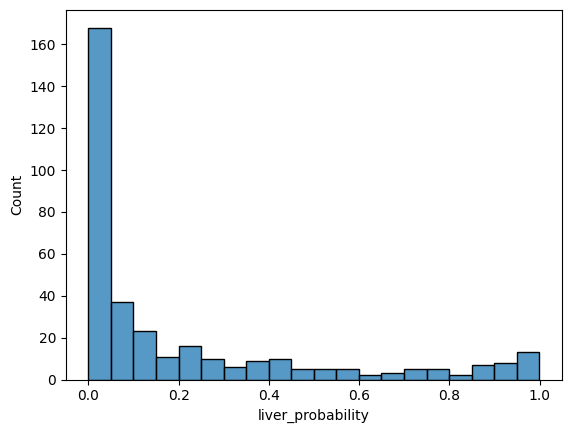

In [90]:
sns.histplot(
    data=hero_data,
    x="liver_probability",
    #hue="sofa_liver_day1",
    palette="Set1", 
    #kde=True,
    multiple="stack", 
    bins=20
)

In [91]:
from joblib import dump


with open("models/liver_protein_model.pkl", "wb") as f:

    dump(lr_clf, f)

with open("models/liver_protein_scaler.pkl", "wb") as f:

    dump(protein_scaler, f)
